In [1]:
import os
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import pandas as pd

In [2]:
# data
DATA_PATH = os.path.join(os.pardir, 'data')
COUNTRY = 'CRO'
DATA = os.path.join(DATA_PATH, COUNTRY)
CONFIRMED_CASES_PATH = os.path.join(
    DATA_PATH, COUNTRY, 'confirmed_cases.dat')
RECOVERED_CASES_PATH = os.path.join(
    DATA_PATH, COUNTRY, 'recovered_cases.dat')
DEATH_CASES_PATH = os.path.join(
    DATA_PATH, COUNTRY, 'death_cases.dat')
TESTS_PATH = os.path.join(
    DATA_PATH, COUNTRY, 'tests.dat')

confirmed_cases = np.loadtxt(CONFIRMED_CASES_PATH)
recovered_cases = np.loadtxt(RECOVERED_CASES_PATH)
death_cases = np.loadtxt(DEATH_CASES_PATH)
daily_tests = np.loadtxt(TESTS_PATH)

epidemics_start_date = dt.datetime(2020, 2, 26)
date_list = [epidemics_start_date + dt.timedelta(days=i) for i in range(confirmed_cases.size)]

# full dataframe
df = pd.DataFrame({
    'date': date_list,
    'confirmed_cases': confirmed_cases,
    'recovered_cases': recovered_cases,
    'death_cases': death_cases,
})
print(df)

          date  confirmed_cases  recovered_cases  death_cases
0   2020-02-26              1.0              0.0          0.0
1   2020-02-27              3.0              0.0          0.0
2   2020-02-28              3.0              0.0          0.0
3   2020-02-29              5.0              0.0          0.0
4   2020-03-01              6.0              0.0          0.0
..         ...              ...              ...          ...
200 2020-09-13          13368.0          10721.0        218.0
201 2020-09-14          13533.0          10899.0        224.0
202 2020-09-15          13598.0          11151.0        227.0
203 2020-09-16          13749.0          11412.0        230.0
204 2020-09-17          14029.0          11690.0        236.0

[205 rows x 4 columns]


In [3]:
def ordinary_least_squares(x, y):
    """Return the intercept and the bias of the linear regression line for (x, y) data.
    Implementation details: https://en.wikipedia.org/wiki/Ordinary_least_squares 
    
    Parameters
    ----------
    x : numpy.ndarray
        1-D array of x values.
    y : numpy.ndarray
        1-D array of y values.
    
    Returns
    -------
    tuple
        (intercept, bias)
    """
    assert x.ndim == 1, 'x must be array_like with ndim = 1.'
    assert y.ndim == 1, 'y must be array_like with ndim = 1.'
    x_col = x.reshape(-1, 1)
    x_col_bias = np.c_[x_col, np.ones(x_col.shape)]
    y_col = y.reshape(-1, 1)
    sol = np.linalg.pinv(x_col_bias.T @ x_col_bias) @ x_col_bias.T @ y_col 
    return (sol[0, 0], sol[1, 0])

In [4]:
def fit_and_plot(
    confirmed_cases, 
    death_cases, 
    death_offset=22, 
    extrapolation_addon_confirmed_cases=50,
):
    """Linear fit delayed number of new death cases over new daily infected cases.
    
    confirmed_cases : numpy.ndarray
        Time series of confirmed infections.
    death_cases : numpy.ndarray
        Time series of confirmed deaths.
    death_offset : int, optional
        Number of days from infection until death.
    extrapolation_addon_confirmed_cases : int, optional
        Number of additional infections to predict deaths to.
    """
    x = np.diff(confirmed_cases)[:-death_offset]
    y = np.diff(death_cases)[death_offset:]

    k, l = ordinary_least_squares(x, y)

    plt.plot(x, y, 'bo', label='Data')
    plt.plot(x, k*x + l, 'r-', label='Linear fit')
    plt.plot(
        np.arange(np.max(x), np.max(x) + extrapolation_addon_confirmed_cases), 
        k*np.arange(np.max(x), np.max(x) + extrapolation_addon_confirmed_cases) + l, 
        'r--', label='Linear extrapolation',
    )
    plt.text(
        np.max(x), k*np.max(x) + l, f'k = {round(k, 5)}',
        verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.xlabel('New confirmed infections daily')
    plt.ylabel('New death cases daily')
    plt.title(f'{death_offset} days delayed death cases over new daily cases')
    plt.legend()
    plt.grid()
    plt.show()

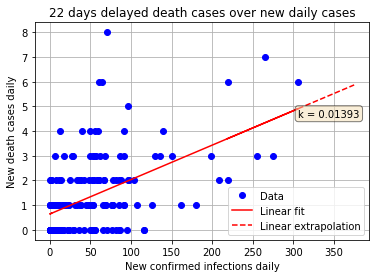

In [5]:
# full data set
fit_and_plot(
    confirmed_cases=df.confirmed_cases, 
    death_cases=df.death_cases, 
    death_offset=22, 
    extrapolation_addon_confirmed_cases=70,
)

         date  confirmed_cases  recovered_cases  death_cases
0  2020-02-26              1.0              0.0          0.0
1  2020-02-27              3.0              0.0          0.0
2  2020-02-28              3.0              0.0          0.0
3  2020-02-29              5.0              0.0          0.0
4  2020-03-01              6.0              0.0          0.0
..        ...              ...              ...          ...
92 2020-05-28           2244.0           2047.0        101.0
93 2020-05-29           2245.0           2051.0        102.0
94 2020-05-30           2245.0           2059.0        103.0
95 2020-05-31           2246.0           2063.0        103.0
96 2020-06-01           2246.0           2072.0        103.0

[97 rows x 4 columns]


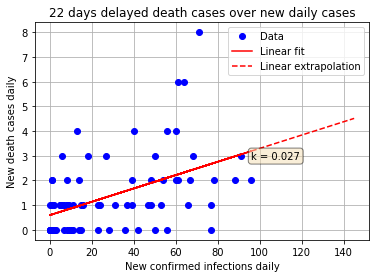

In [6]:
# first wave data dataframe
df_1 = df[df.date<=dt.datetime(2020, 6, 1)]
df_1 = df_1.reset_index(drop=True)
print(df_1)

fit_and_plot(
    confirmed_cases=df_1.confirmed_cases, 
    death_cases=df_1.death_cases, 
    death_offset=22, 
    extrapolation_addon_confirmed_cases=50,
)

          date  confirmed_cases  recovered_cases  death_cases
0   2020-06-02           2246.0           2077.0        103.0
1   2020-06-03           2246.0           2088.0        103.0
2   2020-06-04           2246.0           2095.0        103.0
3   2020-06-05           2247.0           2105.0        103.0
4   2020-06-06           2247.0           2113.0        103.0
..         ...              ...              ...          ...
103 2020-09-13          13368.0          10721.0        218.0
104 2020-09-14          13533.0          10899.0        224.0
105 2020-09-15          13598.0          11151.0        227.0
106 2020-09-16          13749.0          11412.0        230.0
107 2020-09-17          14029.0          11690.0        236.0

[108 rows x 4 columns]


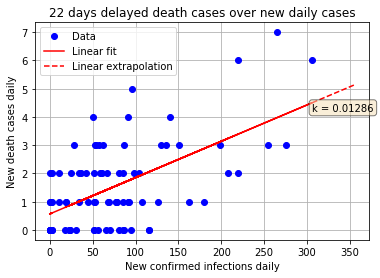

In [7]:
# second wave data dataframe
df_2 = df[df.date>dt.datetime(2020, 6, 1)]
df_2 = df_2.reset_index(drop=True)
print(df_2)

fit_and_plot(
    confirmed_cases=df_2.confirmed_cases, 
    death_cases=df_2.death_cases, 
    death_offset=22, 
    extrapolation_addon_confirmed_cases=50,
)